In [1]:
import pydicom
from pydicom import dcmread

import pandas as pd
from pandas import DataFrame

import numpy as np

from numba import jit
import cv2

import os

import scipy as st
from scipy.constants import e, h, c

In [2]:
def import_dicom(in_dir_path):
    #names the path to the input model directory, and lists the files in this directory

    in_dir_list = sorted(os.listdir(in_dir_path))
    model_depth = len(in_dir_list)
    model_data = []


    i = 0
    while i < model_depth:
        path = in_dir_path + "/" + in_dir_list[i]
        current_slice = pydicom.dcmread(path)
        model_slice = current_slice.pixel_array
        model_slice = np.asarray(model_slice)
        model_data.append(model_slice)
        i = i + 1
    model_data = np.asarray(model_data, dtype = np.int16)
    
        
    return model_data

In [3]:
def find_model_kVp(in_dir_path):   
    in_dir_list = sorted(os.listdir(in_dir_path))
    path = in_dir_path + "/" + in_dir_list[0]
    first_slice = pydicom.dcmread(path)
    model_kVp = first_slice[0x0018, 0x0060].value
    return model_kVp

In [4]:
def find_known_KeV(mat_dir_path):    
    mat_dir_list = os.listdir(mat_dir_path)
    first_file_path = mat_dir_path + "/" + mat_dir_list[0]
    first_file = pd.read_csv(first_file_path)    
    known_KeV = first_file[first_file.columns[0]].values.tolist()
    known_KeV = np.asarray(known_KeV)
    return known_KeV

In [5]:
def find_known_CT_numbers(mat_dir_path):
    mat_dir_path = mat_dir_path + "/CT_numbers"
    mat_dir_list = sorted(os.listdir(mat_dir_path))
            
    tissue_types = []
    for x in mat_dir_list:
        tissue_types.append(x.replace(".csv", ""))
        #x.replace() removes the file type, to leave just the tissue name
       
    tissue_data = []
    for x in mat_dir_list:
        mat_path = mat_dir_path + "/" + x
        curent_file = pd.read_csv(mat_path)
        current_tissue_data = curent_file[curent_file.columns[1]].values.tolist()
        current_tissue_data = np.asarray(current_tissue_data)
        tissue_data.append(current_tissue_data)
    
    tissue_types = np.asarray(tissue_types)
    tissue_data = np.asarray(tissue_data)
    
    known_CT_numbers=[tissue_types, tissue_data]  
    
    return known_CT_numbers

In [6]:
def predict_CT_numbers(target_KeV, known_CT_numbers, known_KeV):
    
    #finds the closest two known KeVs
    
    #calculates the index of the nearest value more than the kVp
    upper_i = 0
        
    while known_KeV[upper_i] < target_KeV:
            upper_i = upper_i + 1


    #calculates the index of the nearest value less than the kVp
    lower_i = 0      
    if target_KeV >= known_KeV[0]:
        while known_KeV[lower_i] > target_KeV:
            lower_i = lower_i - 1

        
        
    upper_KeV = known_KeV[upper_i]
    lower_KeV = known_KeV[lower_i]
        
    if (upper_KeV == target_KeV):
        upper_KeV_weight = 1
        lower_KeV_weight = 0
    elif (lower_KeV == target_KeV):
        upper_KeV_weight = 0
        lower_KeV_weight = 1
    else:
        #solution to the simultaneous equations
        #target_KeV = upper_KeV_weight*upper_KeV + lower_KeV_weight*lower_KeV
        #AND
        #upper_KeV_weight + lower_KeV_weight = 1
        #which express the KeV as a weighted average of two known values
        upper_KeV_weight = (target_KeV - lower_KeV)/(upper_KeV-lower_KeV + 0.00000000001)
        #adding a very small number to to denominator to avoid ever dividing by 0
        lower_KeV_weight = 1- upper_KeV_weight
    
    #finds the expected CT number of each material at the keV that the scan was taken at
    predicted_CT_numbers = []
  
    material_ids = known_CT_numbers[0]
    
    material_number = []
    for x in known_CT_numbers[1]:
        value_to_append = upper_KeV_weight * x[upper_i] + lower_KeV_weight * x[lower_i]
        material_number.append(value_to_append)
        
    
    material_number_sorted = sorted(material_number)
    sorting_indexs = np.argsort(material_number)

    material_ids_sorted = [0] * len(material_ids)
    
    i = 0
    for x in sorting_indexs:
        material_ids_sorted[i] = material_ids[x]
        i = i + 1
        
    material_ids_sorted = np.asarray(material_ids_sorted)
    material_number_sorted = np.asarray(material_number_sorted)
    
    

    predicted_CT_numbers = [material_ids_sorted, material_number_sorted]
    return predicted_CT_numbers

In [7]:
def generate_filtered_spectrum(kVp, interval, anode_atomic_number, filter_thickness):
    
    K = anode_atomic_number
    c = st.constants.c
    h_joules = st.constants.h
    
    bins = np.arange(0, kVp, interval)  
    unfiltered_binned_spectrum = np.zeros((2, len(bins)))
    e = st.constants.elementary_charge
    h = 1000 * e * h_joules
    
    total_integral = ((-K * np.square(kVp)) * (-kVp)) / (6 * np.square(c * h))
    
    i = 0
    while i < len(bins):
        E = bins[i]
        start = ((-K * np.square(E)) * (2*E - 3*kVp)) / (6 * np.square(c * h))        
        end = ((-K * np.square(E + interval)) * (2*(E + interval) - 3*kVp)) / (6 * np.square(c * h))
        integral = end - start
        integral_proportion = integral/total_integral
        unfiltered_binned_spectrum[0][i] = E + 0.5 * interval
        unfiltered_binned_spectrum[1][i] = integral_proportion
        i = i + 1
        
    Al_file = pd.read_csv("./material_info/Al_filter.csv")
    
    Al_lin_atten = Al_file[Al_file.columns[1]].values.tolist()
    Al_lin_atten = np.asarray(Al_lin_atten)
    
    Al_known_KeV = Al_file[Al_file.columns[0]].values.tolist()
    Al_known_KeV = np.asarray(Al_known_KeV)
    
    Al_filter = np.zeros((2, len(unfiltered_binned_spectrum[0])))
    
  
    
    Al_filter[0] = unfiltered_binned_spectrum[0]
   
    
    i = 0
    while i < len(Al_filter[0]):
        dif = abs(Al_filter[0][i] - Al_known_KeV)
        closest_index = np.argmin(dif)
        
        if Al_known_KeV[closest_index] == Al_filter[0][i]:
            upper_KeV = Al_known_KeV[closest_index]
            lower_KeV = Al_known_KeV[closest_index]
            upper_weight = 1
            lower_weight = 0
            upper_u =  Al_lin_atten[closest_index]
            lower_u = Al_lin_atten[closest_index]

        elif Al_known_KeV[closest_index] < Al_filter[0][i]:
            upper_KeV = Al_known_KeV[closest_index + 1]
            lower_KeV = Al_known_KeV[closest_index]
            upper_weight = (Al_filter[0][i] - lower_KeV)/(upper_KeV - lower_KeV)
            lower_weight = 1 - upper_weight
            upper_u =  Al_lin_atten[closest_index + 1]
            lower_u = Al_lin_atten[closest_index]
            
        else:
            upper_KeV = Al_known_KeV[closest_index]
            lower_KeV = Al_known_KeV[closest_index - 1]
            upper_weight = (Al_filter[0][i] - lower_KeV)/(upper_KeV - lower_KeV)
            lower_weight = 1 - upper_weight
            upper_u =  Al_lin_atten[closest_index]
            lower_u = Al_lin_atten[closest_index - 1]
            
        Al_filter[1][i] = upper_weight*upper_u + lower_weight*lower_u
        i = i + 1
        
        
        
    unfiltered_spectrum = unfiltered_binned_spectrum[1]
    product = -Al_filter[1] * filter_thickness

    filter_ratio = np.exp(product)
    
    filtered_spectrum_values = filter_ratio * unfiltered_spectrum
    
    normal_sum = np.sum(filtered_spectrum_values)
    
    normal_filtered_spectrum_values = filtered_spectrum_values/normal_sum
    
    normal_filtered_spectrum = np.zeros((2, len(normal_filtered_spectrum_values)))
    
    normal_filtered_spectrum[0] = unfiltered_binned_spectrum[0]
    normal_filtered_spectrum[1] = normal_filtered_spectrum_values
    
    return(normal_filtered_spectrum)

In [8]:
def predict_CT_numbers_poly(mat_dir_path, kVp, interval, anode_atomic_number, filter_thickness):
    #mat_dir_path is the path to material_info file, or equivalent
    #interval refers to size of the invervals used when calculating x-ray spectra. Smaller interval is faster and lest accurate.
    #filter_thickness is in centimetres
    known_KeV = find_known_KeV(mat_dir_path)
    known_CT_numbers = find_known_CT_numbers(mat_dir_path)
    filtered_spectrum = generate_filtered_spectrum(kVp, interval, anode_atomic_number, filter_thickness)
    
    poly_CT_numbers_unsum = np.zeros((len(filtered_spectrum[0]), len(known_CT_numbers[0])))
    
    i = 0
    while i < len(filtered_spectrum[0]):
        line = predict_CT_numbers(filtered_spectrum[0][i], known_CT_numbers, known_KeV)
        line_val = line[1]
        line_val  = line_val  * filtered_spectrum[1][i]
        poly_CT_numbers_unsum[i] = line_val
   
        i = i + 1
    
    poly_CT_numbers_val = np.sum(poly_CT_numbers_unsum, axis = 0)
    
    poly_CT_numbers = [line[0], poly_CT_numbers_val]
    
    return poly_CT_numbers


In [9]:
def identify_tissue(val, expected_CT_numbers):
    #indentifies the closest match for a given CT number   
    dif = abs(expected_CT_numbers - val)
    tissue_index = np.argmin(dif)
    tissue_type = expected_CT_numbers[0][tissue_index]
    return tissue_type

In [10]:
def mass_density_dictionary(mat_dir_path):
    #creates a dictionary of tissue types and their mass densities
    
    path = mat_dir_path + "/mass_densities.csv"
    density_file = pd.read_csv(path)
    density_file_material_list = density_file[density_file.columns[0]].values.tolist()
    density_file_value_list = density_file[density_file.columns[1]].values.tolist()
    mass_densities = {}

    i = 0
    while i < (len(density_file_material_list)):
        mass_densities.update({density_file_material_list[i] : density_file_value_list[i]})
        i = i + 1
        
    return mass_densities

In [11]:
def find_tissue_ranges(predicted_CT_numbers):
    
    #creates two lists of the predicted CT numbers, offset by one index, for efficient computation using vectorisation
    #the principle is the cut-off between values is the mid point between them, which is also the average
    x = predicted_CT_numbers[1]
    y = predicted_CT_numbers[1]
    
    #offseting by one index
    x = np.insert(x, 0, x[0])
    y = np.insert(y, len(y)-1, y[-1])
    
    #finding average in vectorised way
    z = x + y  
    z = z/2
    
    material_count = len(predicted_CT_numbers[1])
    tissue_ranges = np.zeros((material_count, 2))
    
    i = 0
    while i < material_count:
        tissue_ranges[i][0] = z[i]
        tissue_ranges[i][1] = z[i + 1]
        i = i + 1
    
    
    #expands the top and bottom range
    tissue_ranges[0][0] = tissue_ranges[0][0] * 2
    tissue_ranges[-1][1] = tissue_ranges[-1][1] * 2
 

    

    return tissue_ranges

In [12]:
def find_density_map(model, tissue_ranges, predicted_CT_numbers, mass_densities):
    seg_density_map = np.zeros((len(tissue_ranges), len(model), len(model[0]), len(model[0][0])))
    
    i = 0
    while i < len(tissue_ranges):        
        lower = tissue_ranges[i][0]
        upper = tissue_ranges[i][1]

        mask = np.where((model > lower) & (model < upper), 1, 0)
        
        tissue_type = predicted_CT_numbers[0][i]
        tissue_density = mass_densities[tissue_type]
        
        seg_density_map[i] = tissue_density * mask

        i = i + 1
        
    density_map = np.sum(seg_density_map, axis = 0)

    
    return density_map

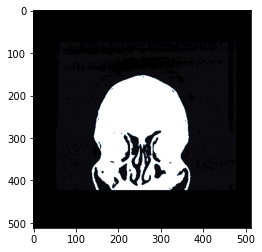

In [25]:
import matplotlib.pyplot as plt

in_dir_path = "./infile"
mat_dir_path = "./material_info"
model = import_dicom(in_dir_path)
model_kVp = find_model_kVp(in_dir_path)

interval = 5
anode_atomic_number = 74
filter_thickness = 0.5


predicted_CT_numbers = predict_CT_numbers_poly(mat_dir_path, model_kVp, interval, anode_atomic_number, filter_thickness)
tissue_ranges = find_tissue_ranges(predicted_CT_numbers)

mass_densities = mass_density_dictionary(mat_dir_path)

density_map = find_density_map(model, tissue_ranges, predicted_CT_numbers, mass_densities)

plt.imshow(density_map[23], cmap=plt.cm.bone)